In [1]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [160]:
def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):
        if (image_name.split('.')[1] == 'npy'):
            image = np.load(img_dir+image_name)
            # print("Image - ",image.shape)
            images.append(image)
    images = np.array(images)

    return(images)

def load_msk(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):
        if (image_name.split('.')[1] == 'npy'):
            image = np.load(img_dir+image_name)
            # print("before - ",image.shape)
            image = to_categorical(image, num_classes=4)
            # print("After - ",image.shape)
            images.append(image)
    images = np.array(images)

    return(images)

def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_msk(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples
            batch_start += batch_size
            batch_end += batch_size



def load_scan(parent_path,folder,start_slice,end_slice):
    images=[]
    labels = []
    test_image_seg= nib.load(f"{parent_path}/{folder}/{folder}-seg.nii.gz").get_fdata()
    test_image_seg = test_image_seg.astype(np.int8)

    test_image_t1c=nib.load(f"{parent_path}/{folder}/{folder}-t1c.nii.gz").get_fdata()
    test_image_t1c=scaler.fit_transform(test_image_t1c.reshape(-1, test_image_t1c.shape[-1])).reshape(test_image_t1c.shape)

    test_image_t1n=nib.load(f"{parent_path}/{folder}/{folder}-t1n.nii.gz").get_fdata()
    test_image_t1n=scaler.fit_transform(test_image_t1n.reshape(-1, test_image_t1n.shape[-1])).reshape(test_image_t1n.shape)

    test_image_t2f=nib.load(f"{parent_path}/{folder}/{folder}-t2f.nii.gz").get_fdata()
    test_image_t2f=scaler.fit_transform(test_image_t2f.reshape(-1, test_image_t2f.shape[-1])).reshape(test_image_t2f.shape)

    test_image_t2w=nib.load(f"{parent_path}/{folder}/{folder}-t2w.nii.gz").get_fdata()
    test_image_t2w=scaler.fit_transform(test_image_t2w.reshape(-1, test_image_t2w.shape[-1])).reshape(test_image_t2w.shape)

    for slice_number in range(start_slice,end_slice):
        print(slice_number)
        test_image_seg_slice = test_image_seg[:,:,slice_number]
        # test_image_seg_slice = to_categorical(test_image_seg_slice, num_classes=4)
        test_image_t1c_slice = test_image_t1c[:,:,slice_number]
        test_image_t1n_slice = test_image_t1n[:,:,slice_number]
        test_image_t2f_slice = test_image_t2f[:,:,slice_number]
        test_image_t2w_slice = test_image_t2w[:,:,slice_number]
        combined_x = np.stack([test_image_t1c_slice,test_image_t1n_slice, test_image_t2f_slice,test_image_t2w_slice], axis=-1)
        labels.append(test_image_seg_slice)
        images.append(combined_x)

    images = np.array(images)
    labels = np.array(labels)

    return(images,labels)


def imageLoader_2(scan_dir, batch_size):

    L = len(scan_dir)
    parent_path = 'F:/FYP/BRATS_dataset/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData'
    #keras needs the generator infinite, so we will use while true
    while True:
        
        slice_range = 32
        batch_size = 5
        for index,scan_folder_name in enumerate(scan_dir):
            first_slice = 64
            for i in range(1,int(slice_range/batch_size)+2):
                print("itter -",i)
                limit = min(batch_end, L)
                if i > int(slice_range/batch_size):
                    X,Y = load_scan(parent_path,scan_folder_name,first_slice,(first_slice+(slice_range%batch_size)))
                else:    
                    X,Y = load_scan(parent_path,scan_folder_name,first_slice,(first_slice+batch_size))
                # X,Y = load_scan(parent_path,scan_folder_name,75,83)

                yield (X,Y) #a tuple with two numpy arrays with batch_size samples
                first_slice = first_slice + batch_size
                

In [161]:
# Replace 'folder_path' with the actual path to your folder
folder_path = 'F:\FYP\BRATS_dataset\ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData'

# Get a list of all subfolder names in the folder
subfolder_names = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]

In [162]:
img_datagen = imageLoader_2(subfolder_names,8)

In [170]:
img, msk = img_datagen.__next__()

itter - 1
64
65
66
67
68


In [101]:
print(img.shape)

(8, 240, 240, 4)


64
65
66
67
68
69
70
71


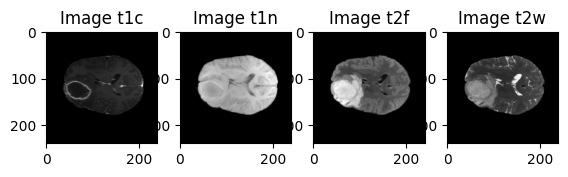

In [155]:
import random
img, msk = img_datagen.__next__()
data_point = random.randint(0, 7)
# data_point = 7

# original_labels = np.expand_dims(msk[data_point,:,:,:], axis=0)
# original_labels = np.argmax(original_labels, axis=3)


plt.subplot(341)
plt.imshow(img[data_point,:,:,0], cmap='gray')
plt.title('Image t1c')
plt.subplot(342)
plt.imshow(img[data_point,:,:,1], cmap='gray')
plt.title('Image t1n')
plt.subplot(343)
plt.imshow(img[data_point,:,:,2], cmap='gray')
plt.title('Image t2f')
plt.subplot(344)
plt.imshow(img[data_point,:,:,3], cmap='gray')
plt.title('Image t2w')
# plt.subplot(345)
# plt.imshow(msk[data_point,:,:,0], cmap='gray')
# plt.title('Label_1')
# plt.subplot(346)
# plt.imshow(msk[data_point,:,:,1], cmap='gray')
# plt.title('Label_2')
# plt.subplot(347)
# plt.imshow(msk[data_point,:,:,2], cmap='gray')
# plt.title('Label_3')
# plt.subplot(348)
# plt.imshow(msk[data_point,:,:,3], cmap='gray')
# plt.title('Label_4')
# plt.subplot(349)
# plt.imshow(original_labels.reshape((240,240)))
# plt.title('Complete label')
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9)
plt.show()

In [80]:
print(8%5)

3
